<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/NASNetMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define your data directories
train_dir = '/content/drive/MyDrive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/MyDrive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/MyDrive/test_imadjust_sobel_diff_alpha0.5'


In [ ]:
# Combine train and validation directories for cross-validation
def gather_paths_and_labels(directory):
    data = []
    for label, class_name in enumerate(['Normal', 'Scol']):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            data.append((os.path.join(class_dir, file), label))
    return np.array(data)

train_data = gather_paths_and_labels(train_dir)
val_data = gather_paths_and_labels(val_dir)
test_data = gather_paths_and_labels(test_dir)

# Merge train and validation data for cross-validation
train_val_data = np.concatenate((train_data, val_data))


In [ ]:
# Model creation function
def create_nasnetmobile_model():
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Cross-validation function
def run_cross_validation(data, n_splits=5, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data[:, 0], data[:, 1])):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_files, val_files = data[train_idx], data[val_idx]

        train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': train_files[:, 0], 'class': train_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=True
        )

        val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
            pd.DataFrame({'filename': val_files[:, 0], 'class': val_files[:, 1]}),
            x_col='filename', y_col='class',
            target_size=(224, 224), batch_size=batch_size, class_mode='binary', shuffle=False
        )

        model = create_nasnetmobile_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping], verbose=1)

        val_labels = val_files[:, 1].astype(int)
        val_preds = (model.predict(val_gen) > 0.5).astype(int).ravel()

        accuracy_list.append((val_preds == val_labels).mean())
        precision_list.append(precision_score(val_labels, val_preds))
        recall_list.append(recall_score(val_labels, val_preds))
        f1_list.append(f1_score(val_labels, val_preds))

    print("\n5-Fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

    return model


In [ ]:
# Run cross-validation
final_model = run_cross_validation(train_val_data)


=== Fold 1/5 ===
Found 171 validated image filenames belonging to 2 classes.
Found 43 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7002 - loss: 0.5569 - val_accuracy: 0.8837 - val_loss: 0.2971
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9069 - loss: 0.2963 - val_accuracy: 0.8837 - val_loss: 0.3006
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9386 - loss: 0.2007 - val_accuracy: 0.9070 - val_loss: 0.2770
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9466 - loss: 0.1381 - val_accuracy: 0.9070 - val_loss: 0.2651
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9196 - loss: 0.2134 - val_accuracy: 0.8140 - val_loss: 0.3418
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9559 - loss: 0.1216 - val_accuracy: 0.9070 - val_loss: 0.2489
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9467 - loss: 0.1466 - val_accuracy: 0.9070 - val_loss: 0.2562
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9778 - loss: 0.0795 - val_accuracy: 0.9070 - val_loss: 0.2532
Epoch 9/5

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.6454 - loss: 0.5898 - val_accuracy: 0.8605 - val_loss: 0.2990
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8736 - loss: 0.2970 - val_accuracy: 0.9070 - val_loss: 0.3112
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9078 - loss: 0.2378 - val_accuracy: 0.9302 - val_loss: 0.2375
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9069 - loss: 0.2310 - val_accuracy: 0.9302 - val_loss: 0.2108
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9713 - loss: 0.1358 - val_accuracy: 0.9070 - val_loss: 0.2346
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9578 - loss: 0.1301 - val_accuracy: 0.9767 - val_loss: 0.2054
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9561 - loss: 0.1172 - val_accuracy: 0.9535 - val_loss: 0.2171
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9633 - loss: 0.0900 - val_accuracy: 0.9070 - val_loss: 0.2914
Epoch 9/5

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.6756 - loss: 0.5094 - val_accuracy: 0.8837 - val_loss: 0.3158
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9152 - loss: 0.2445 - val_accuracy: 0.8837 - val_loss: 0.2329
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8688 - loss: 0.2736 - val_accuracy: 0.9302 - val_loss: 0.1769
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9269 - loss: 0.1818 - val_accuracy: 0.9535 - val_loss: 0.1552
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9309 - loss: 0.1543 - val_accuracy: 0.9302 - val_loss: 0.1520
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9307 - loss: 0.1543 - val_accuracy: 0.9302 - val_loss: 0.1379
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9582 - loss: 0.1491 - val_accuracy: 0.9535 - val_loss: 0.1444
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9579 - loss: 0.0917 - val_accuracy: 0.9302 - val_loss: 0.1377
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - accuracy: 0.5877 - loss: 0.7105 - val_accuracy: 0.7907 - val_loss: 0.4091
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8679 - loss: 0.3222 - val_accuracy: 0.9302 - val_loss: 0.3038
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8590 - loss: 0.2948 - val_accuracy: 0.8837 - val_loss: 0.2907
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9095 - loss: 0.2197 - val_accuracy: 0.9070 - val_loss: 0.2417
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9389 - loss: 0.1628 - val_accuracy: 0.9070 - val_loss: 0.2284
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9574 - loss: 0.1627 - val_accuracy: 0.9070 - val_loss: 0.2484
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9516 - loss: 0.1406 - val_accuracy: 0.9070 - val_loss: 0.2101
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9411 - loss: 0.1496 - val_accuracy: 0.9302 - val_loss: 0.2065
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7016 - loss: 0.5121 - val_accuracy: 0.9048 - val_loss: 0.3039
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8594 - loss: 0.2938 - val_accuracy: 0.7619 - val_loss: 0.2689
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9224 - loss: 0.2387 - val_accuracy: 0.9286 - val_loss: 0.2475
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9432 - loss: 0.1476 - val_accuracy: 0.8810 - val_loss: 0.2341
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9188 - loss: 0.1562 - val_accuracy: 0.8810 - val_loss: 0.2244
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9525 - loss: 0.1154 - val_accuracy: 0.8810 - val_loss: 0.2167
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9475 - loss: 0.1324 - val_accuracy: 0.8810 - val_loss: 0.1946
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9740 - loss: 0.1193 - val_accuracy: 0.8571 - val_loss: 0.2293
Epoch 

In [ ]:
# Test set evaluation
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    pd.DataFrame({'filename': test_data[:, 0], 'class': test_data[:, 1]}),
    x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_labels = test_data[:, 1].astype(int)
test_preds = (final_model.predict(test_gen) > 0.5).astype(int).ravel()


Found 41 validated image filenames belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step



Test Set Confusion Matrix:
[[ 9  3]
 [ 1 28]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.75      0.82        12
        Scol       0.90      0.97      0.93        29

    accuracy                           0.90        41
   macro avg       0.90      0.86      0.88        41
weighted avg       0.90      0.90      0.90        41



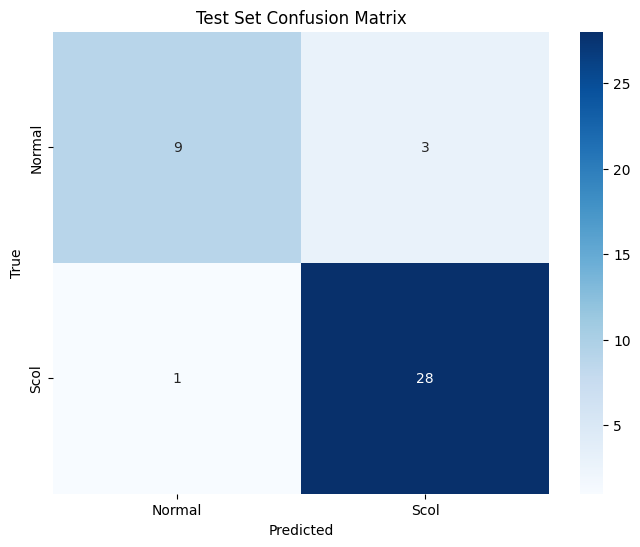

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Scol']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Scol'], yticklabels=['Normal', 'Scol'])
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
